***ℏarlz***

# Enhancing Legal Research: RAG Application with Knowledge Graphs and Court Case Data


Welcome to today's session, where we’ll dive into building a RAG application powered by a Knowledge Graph. Our focus will be on leveraging structured data relationships to enhance query responses using Philippine Supreme Court case data as a source of legal insights. We’ll explore how a well-constructed Knowledge Graph can improve data retrieval, context generation, and overall application intelligence. Let's get started!

# What is a Knowledge Graph?

#### A **knowledge graph** is an organized representation of real-world entities and their relationships. It is typically stored in a graph database, which natively stores the relationships between data entities. Entities in a knowledge graph can represent objects, events, situations, or concepts. The relationships between these entities capture the context and meaning of how they are connected.

#### To put simply, it is like a smart, dynamic map that shows how things in the real world are connected. Imagine a web where each point represents a person, place, event, or concept, and the lines between them show how they relate — similar to how a social network maps your connections to friends, friends of friends, and shared experiences.

#### The key strength of a knowledge graph is its ability to organize and contextualize relationships, not just store raw facts. This makes it incredibly powerful for real-time recommendations, complex searches, and even powering smarter AI systems that need to "understand" the meaning behind data.

# Key Characteristics of a Knowledge Graph



## Nodes
**Nodes** denote and store details about entities, such as people, places, objects, or institutions. Each node has a (or sometimes several) label to identify the node type and may optionally have one or more properties. Nodes are also sometimes called vertices (graph theory).

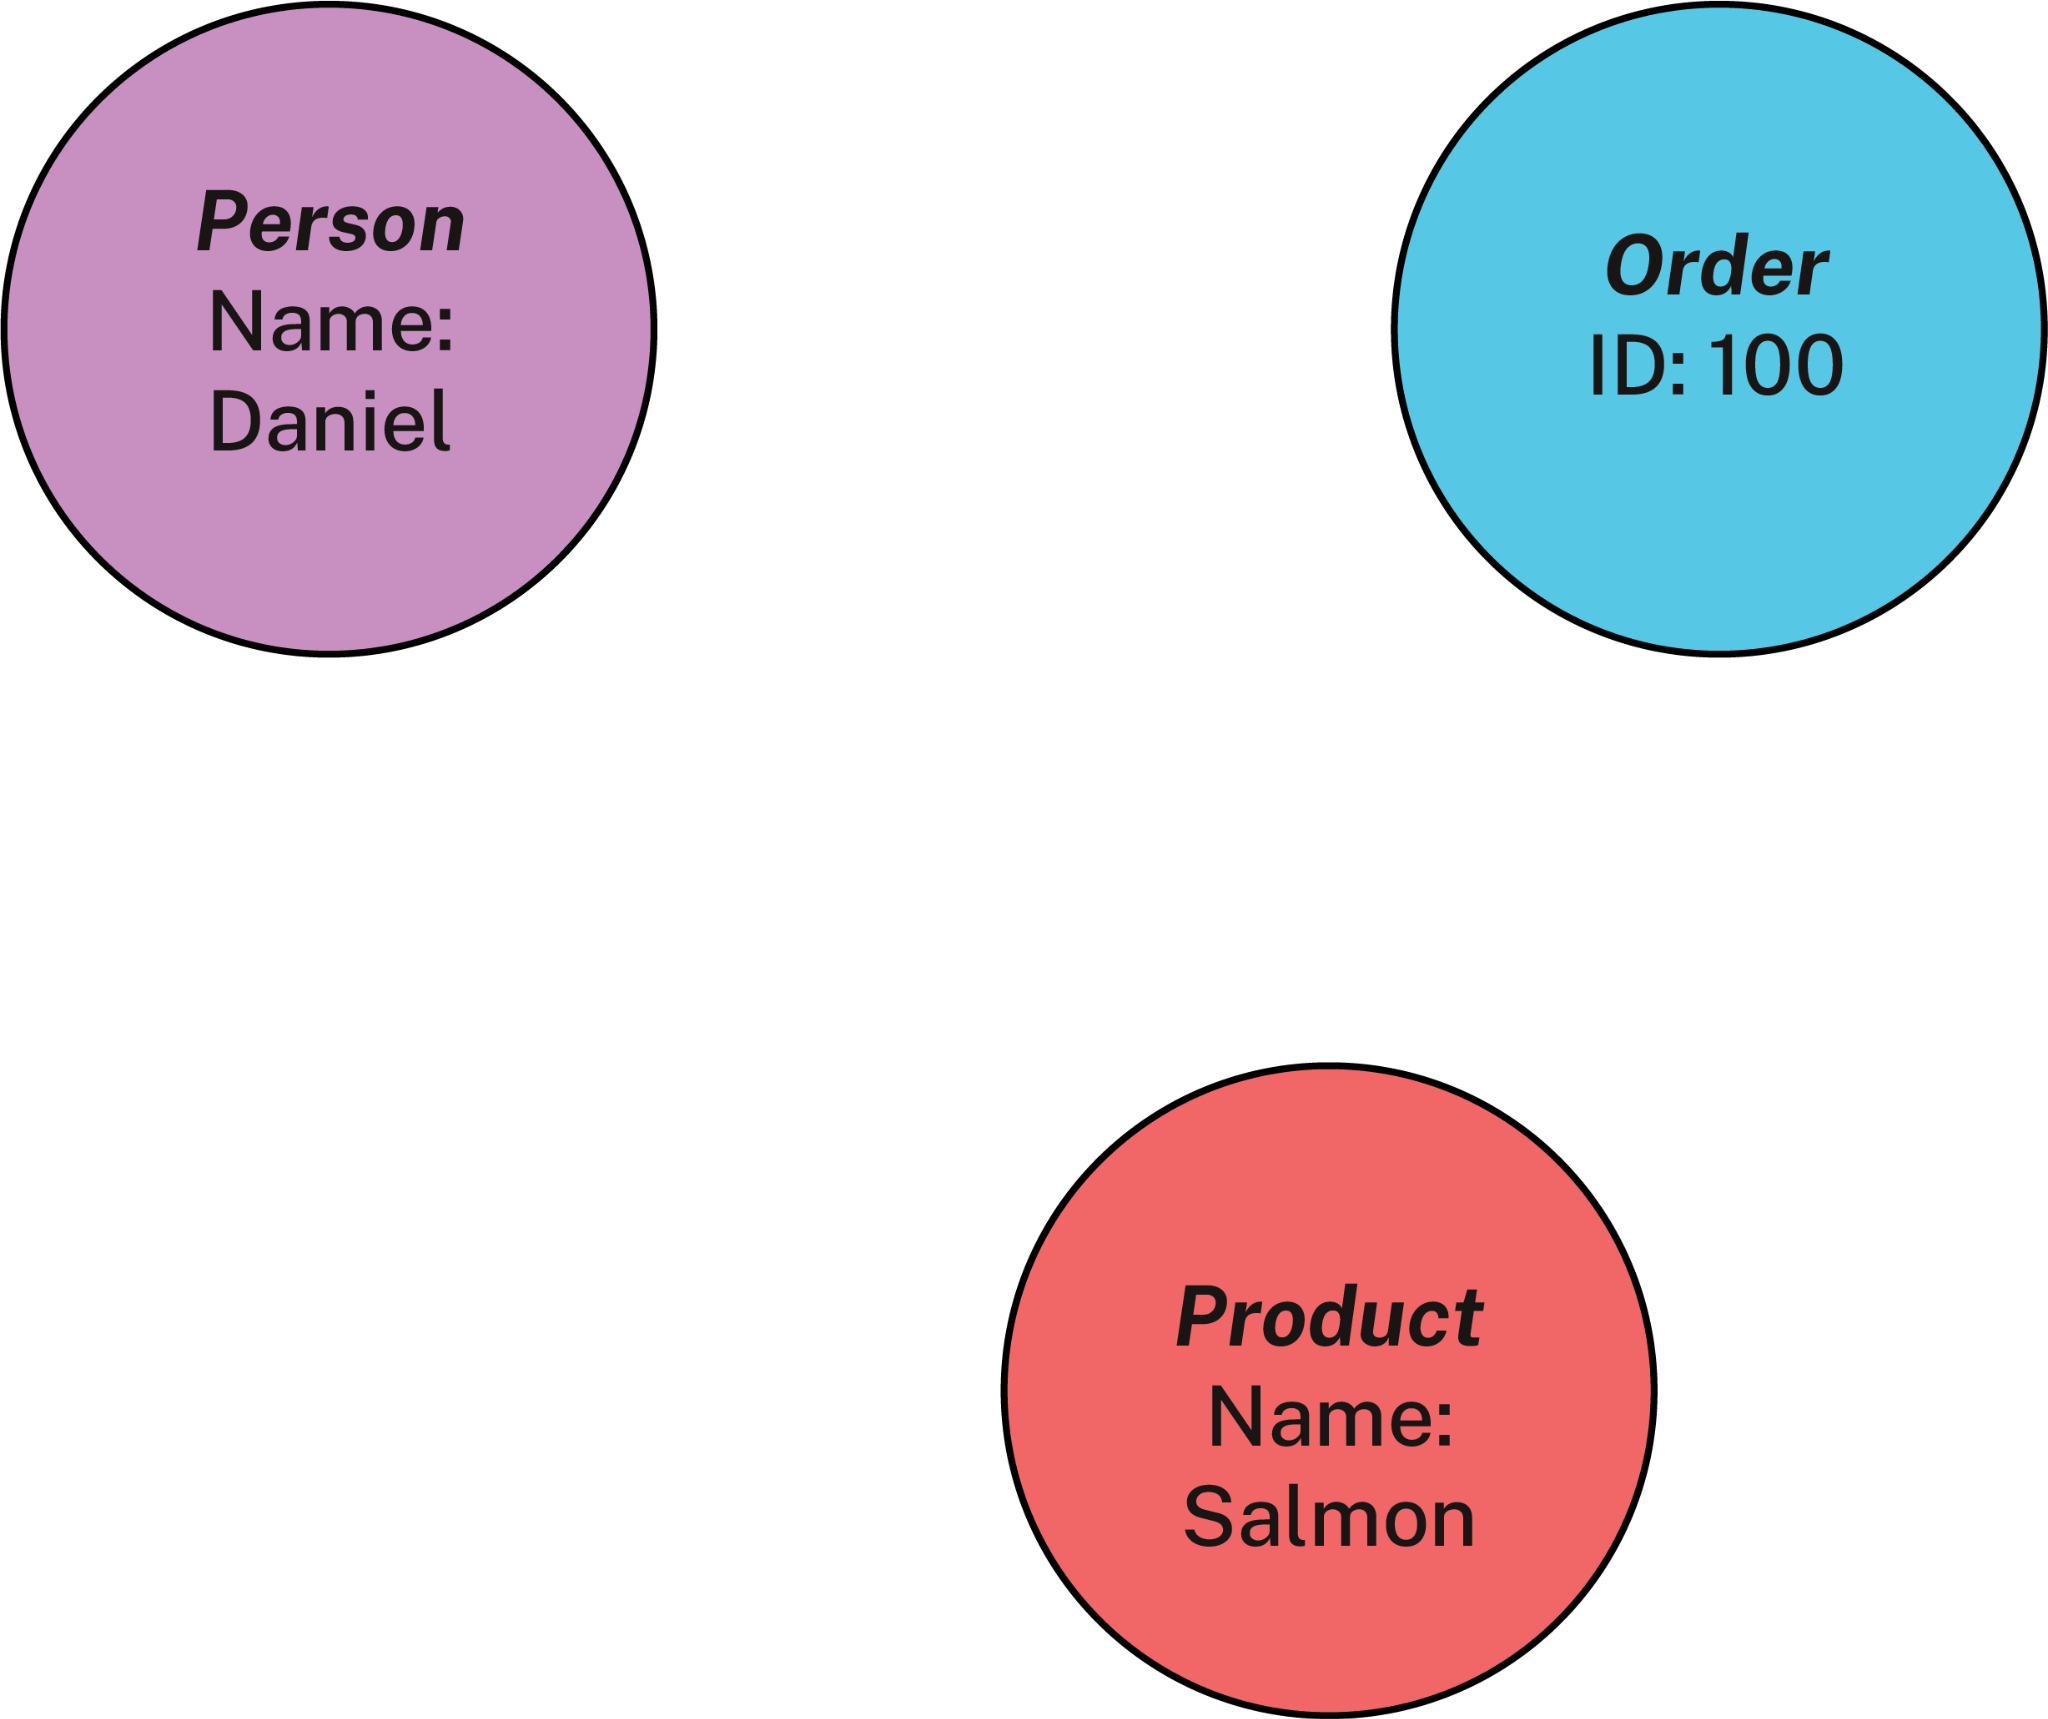

## Relationships

***Relationships*** link two nodes together: they show how the entities are related. Like nodes, each relationship has a label identifying the relationship type and may optionally have one or more properties. Relationships are also sometimes called edges.


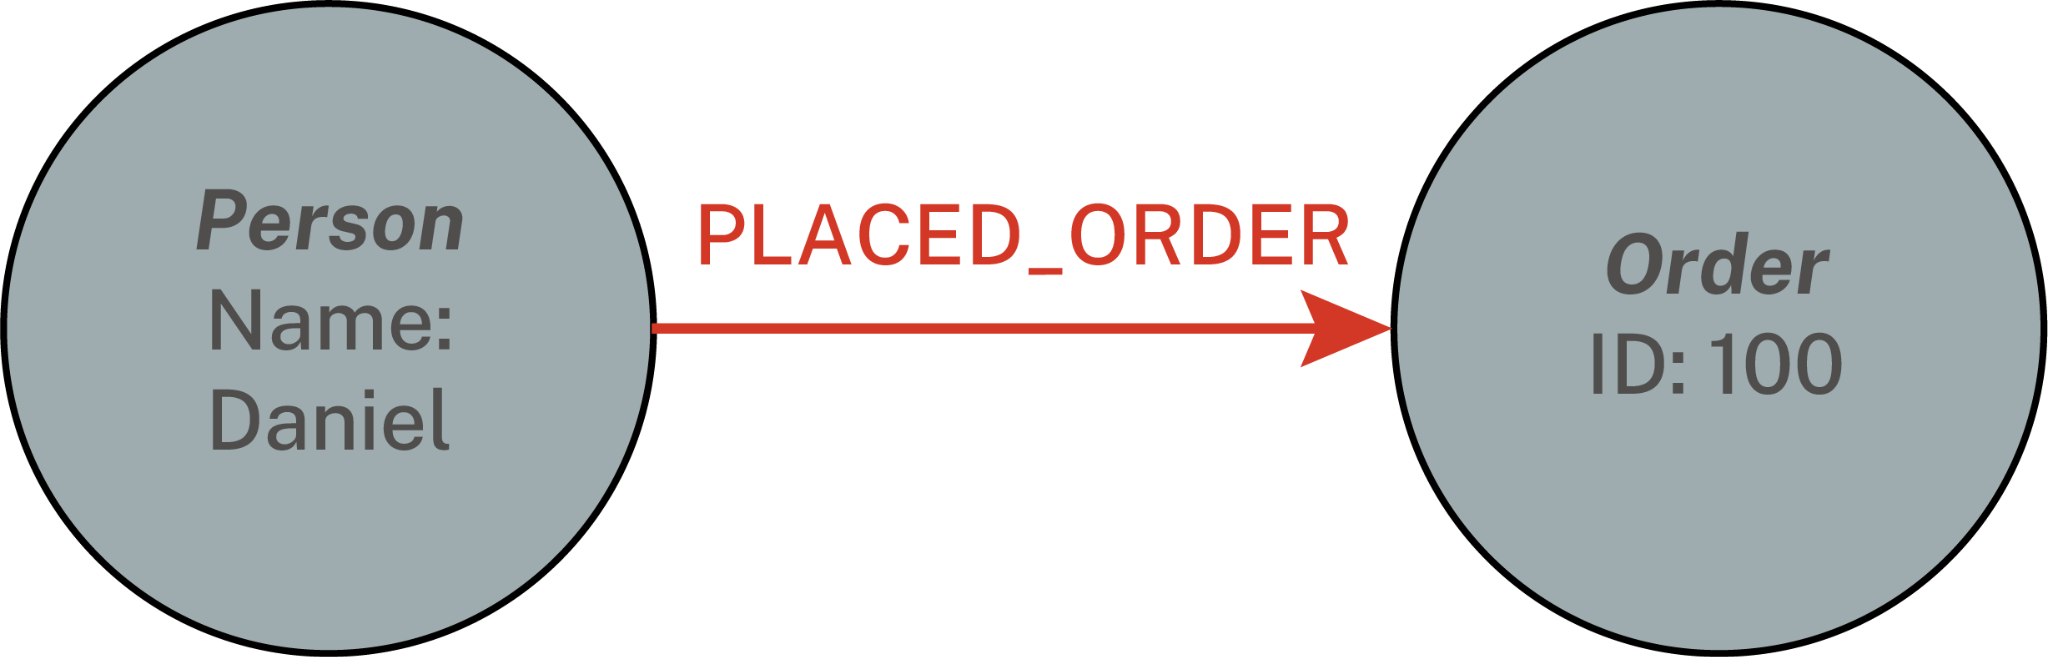

## Organizing Principles

***Organizing Principles*** are a framework that organizes nodes and relationships according to fundamental concepts essential to the use cases at hand. Think of an organizing principle as a conceptual map or metadata layer overlaying the data and relationships in the graph.

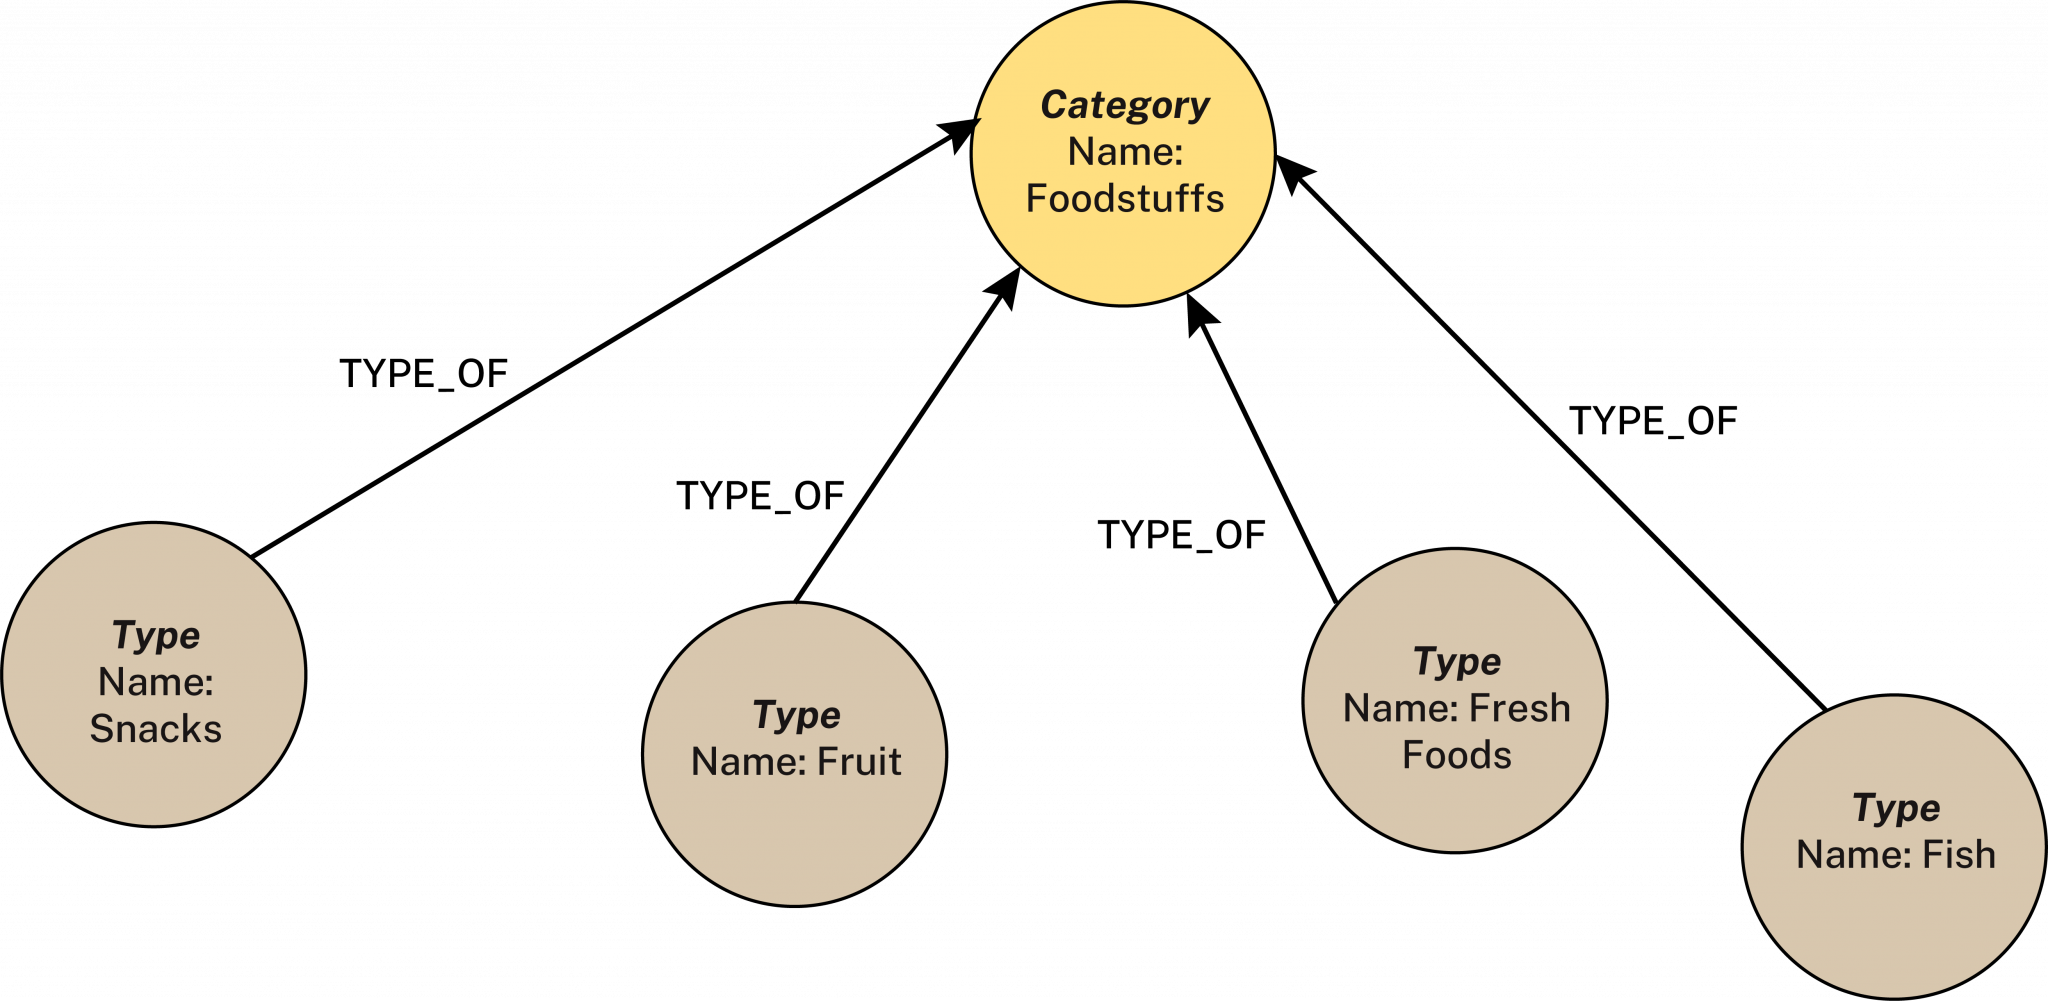

# Example of a Knowledge Graph

Below is a simple knowledge graph of the e-commerce example that shows nodes as circles and relationships between them as arrows. The organizing principles are also stored as nodes and relationships, so the illustration uses some color shading to show which nodes and relationships are the instance data and which are the organizing principles:


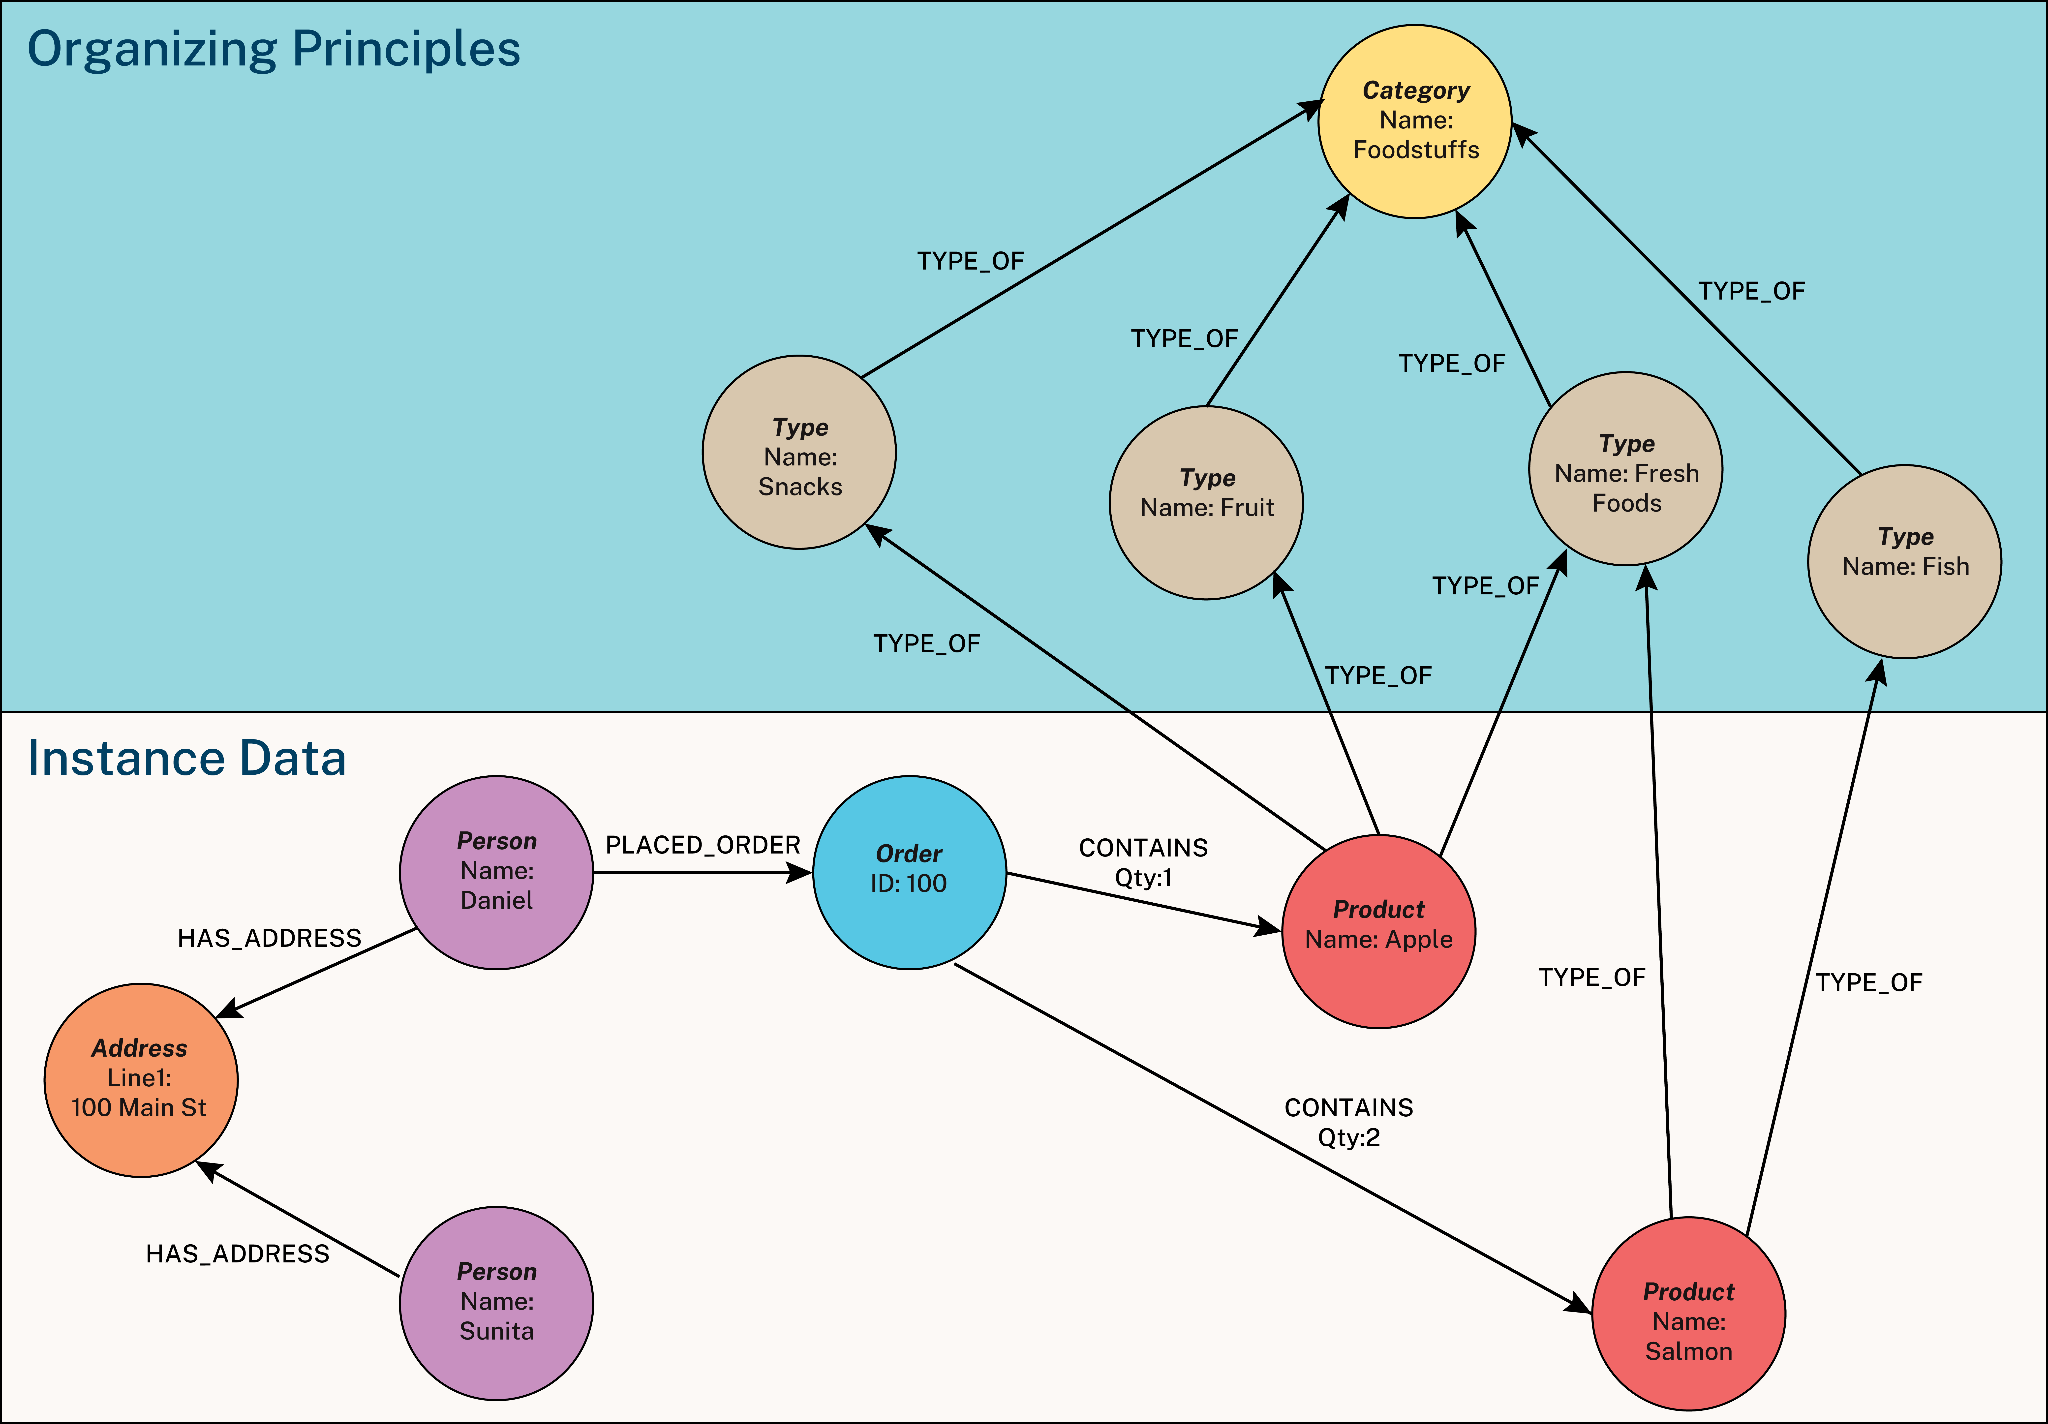

# Application of Knowledge Graph with Generative AI

Knowledge graphs provide a powerful way to store and organize data, enabling deeper and more sophisticated insights. By storing text embedding values as node properties, they support vector similarity searches for task descriptions, just as a vector database would.

GraphRAG is an advanced technique that enhances Retrieval-Augmented Generation (RAG) by integrating knowledge graphs. In this guide, we’ll demonstrate how to implement a GraphRAG application using LangChain for a legal research scenario.


## Some Requisites

**Neo4j Environment Setup**

We'll use Neo4J as our graph database. Indeed, we need to setup an instance for this. For this demo, we'll utilize a free cloud instance of the Neo4J database on [Neo4J Aura](https://neo4j.com/product/auradb/).

**Installing Dependencies**

In [ ]:
!pip install neo4j pandas openai transformers sentence-transformers langchain-community langchain tiktoken langchain_openai langchainhub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.9/311.9 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 50.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 51.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.7/54.7 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.0/413.0 kB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 59.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 69.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56

## Building Our GenAI Application with Neo4J Knowledge Graph

### Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
from neo4j import GraphDatabase
from google.colab import userdata


# Database configuration which can be retrieved in Neo4J Aura
NEO4J_URI = userdata.get('neo4j_uri')
NEO4J_USERNAME = userdata.get('neo4j_username')
NEO4J_PASSWORD = userdata.get('neo4j_password')

def load_data_to_neo4j():
    driver = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USERNAME, NEO4J_PASSWORD))

    cases_file = '/content/drive/MyDrive/AI datasets/cases.csv'
    justices_file = '/content/drive/MyDrive/AI datasets/justices.csv'
    keywords_file = '/content/drive/MyDrive/AI datasets/case_keywords.csv'

    cases_df = pd.read_csv(cases_file)
    justices_df = pd.read_csv(justices_file)
    keywords_df = pd.read_csv(keywords_file)

    def create_case_node(tx, row):
        query = f"""
        CREATE (c:Case {{
            case_id: '{row["case_id"]}',
            title: '{row["title"]}',
            date_decided: '{row["date_decided"]}',
            summary: '{row["summary"]}'
        }})
        """
        tx.run(query)

    def create_keyword_node(tx, case_id, keyword):
        query = f"""
        MATCH (c:Case {{case_id: '{case_id}'}})
        MERGE (k:Keyword {{name: '{keyword}'}})
        MERGE (c)-[:HAS_KEYWORD]->(k)
        """
        tx.run(query)

    def create_justice_node(tx, row):
        query = f"""
        CREATE (j:Justice {{
            justice_id: '{row["justice_id"]}',
            name: '{row["name"]}',
            role: '{row["role"]}',
            affiliation: '{row["affiliation"]}'
        }})
        """
        tx.run(query)

    # Load data
    with driver.session() as session:
        for _, row in cases_df.iterrows():
            session.execute_write(create_case_node, row)

        # for _, row in justices_df.iterrows():
        #     session.execute_write(create_justice_node, row)

        for _, row in keywords_df.iterrows():
            session.execute_write(create_keyword_node, row["case_id"], row["keyword"])

    driver.close()
    print("Data loaded successfully into Neo4j.")

In [ ]:
load_data_to_neo4j()

Data loaded successfully into Neo4j.


Let's visualize it [here](https://browser.neo4j.io/).

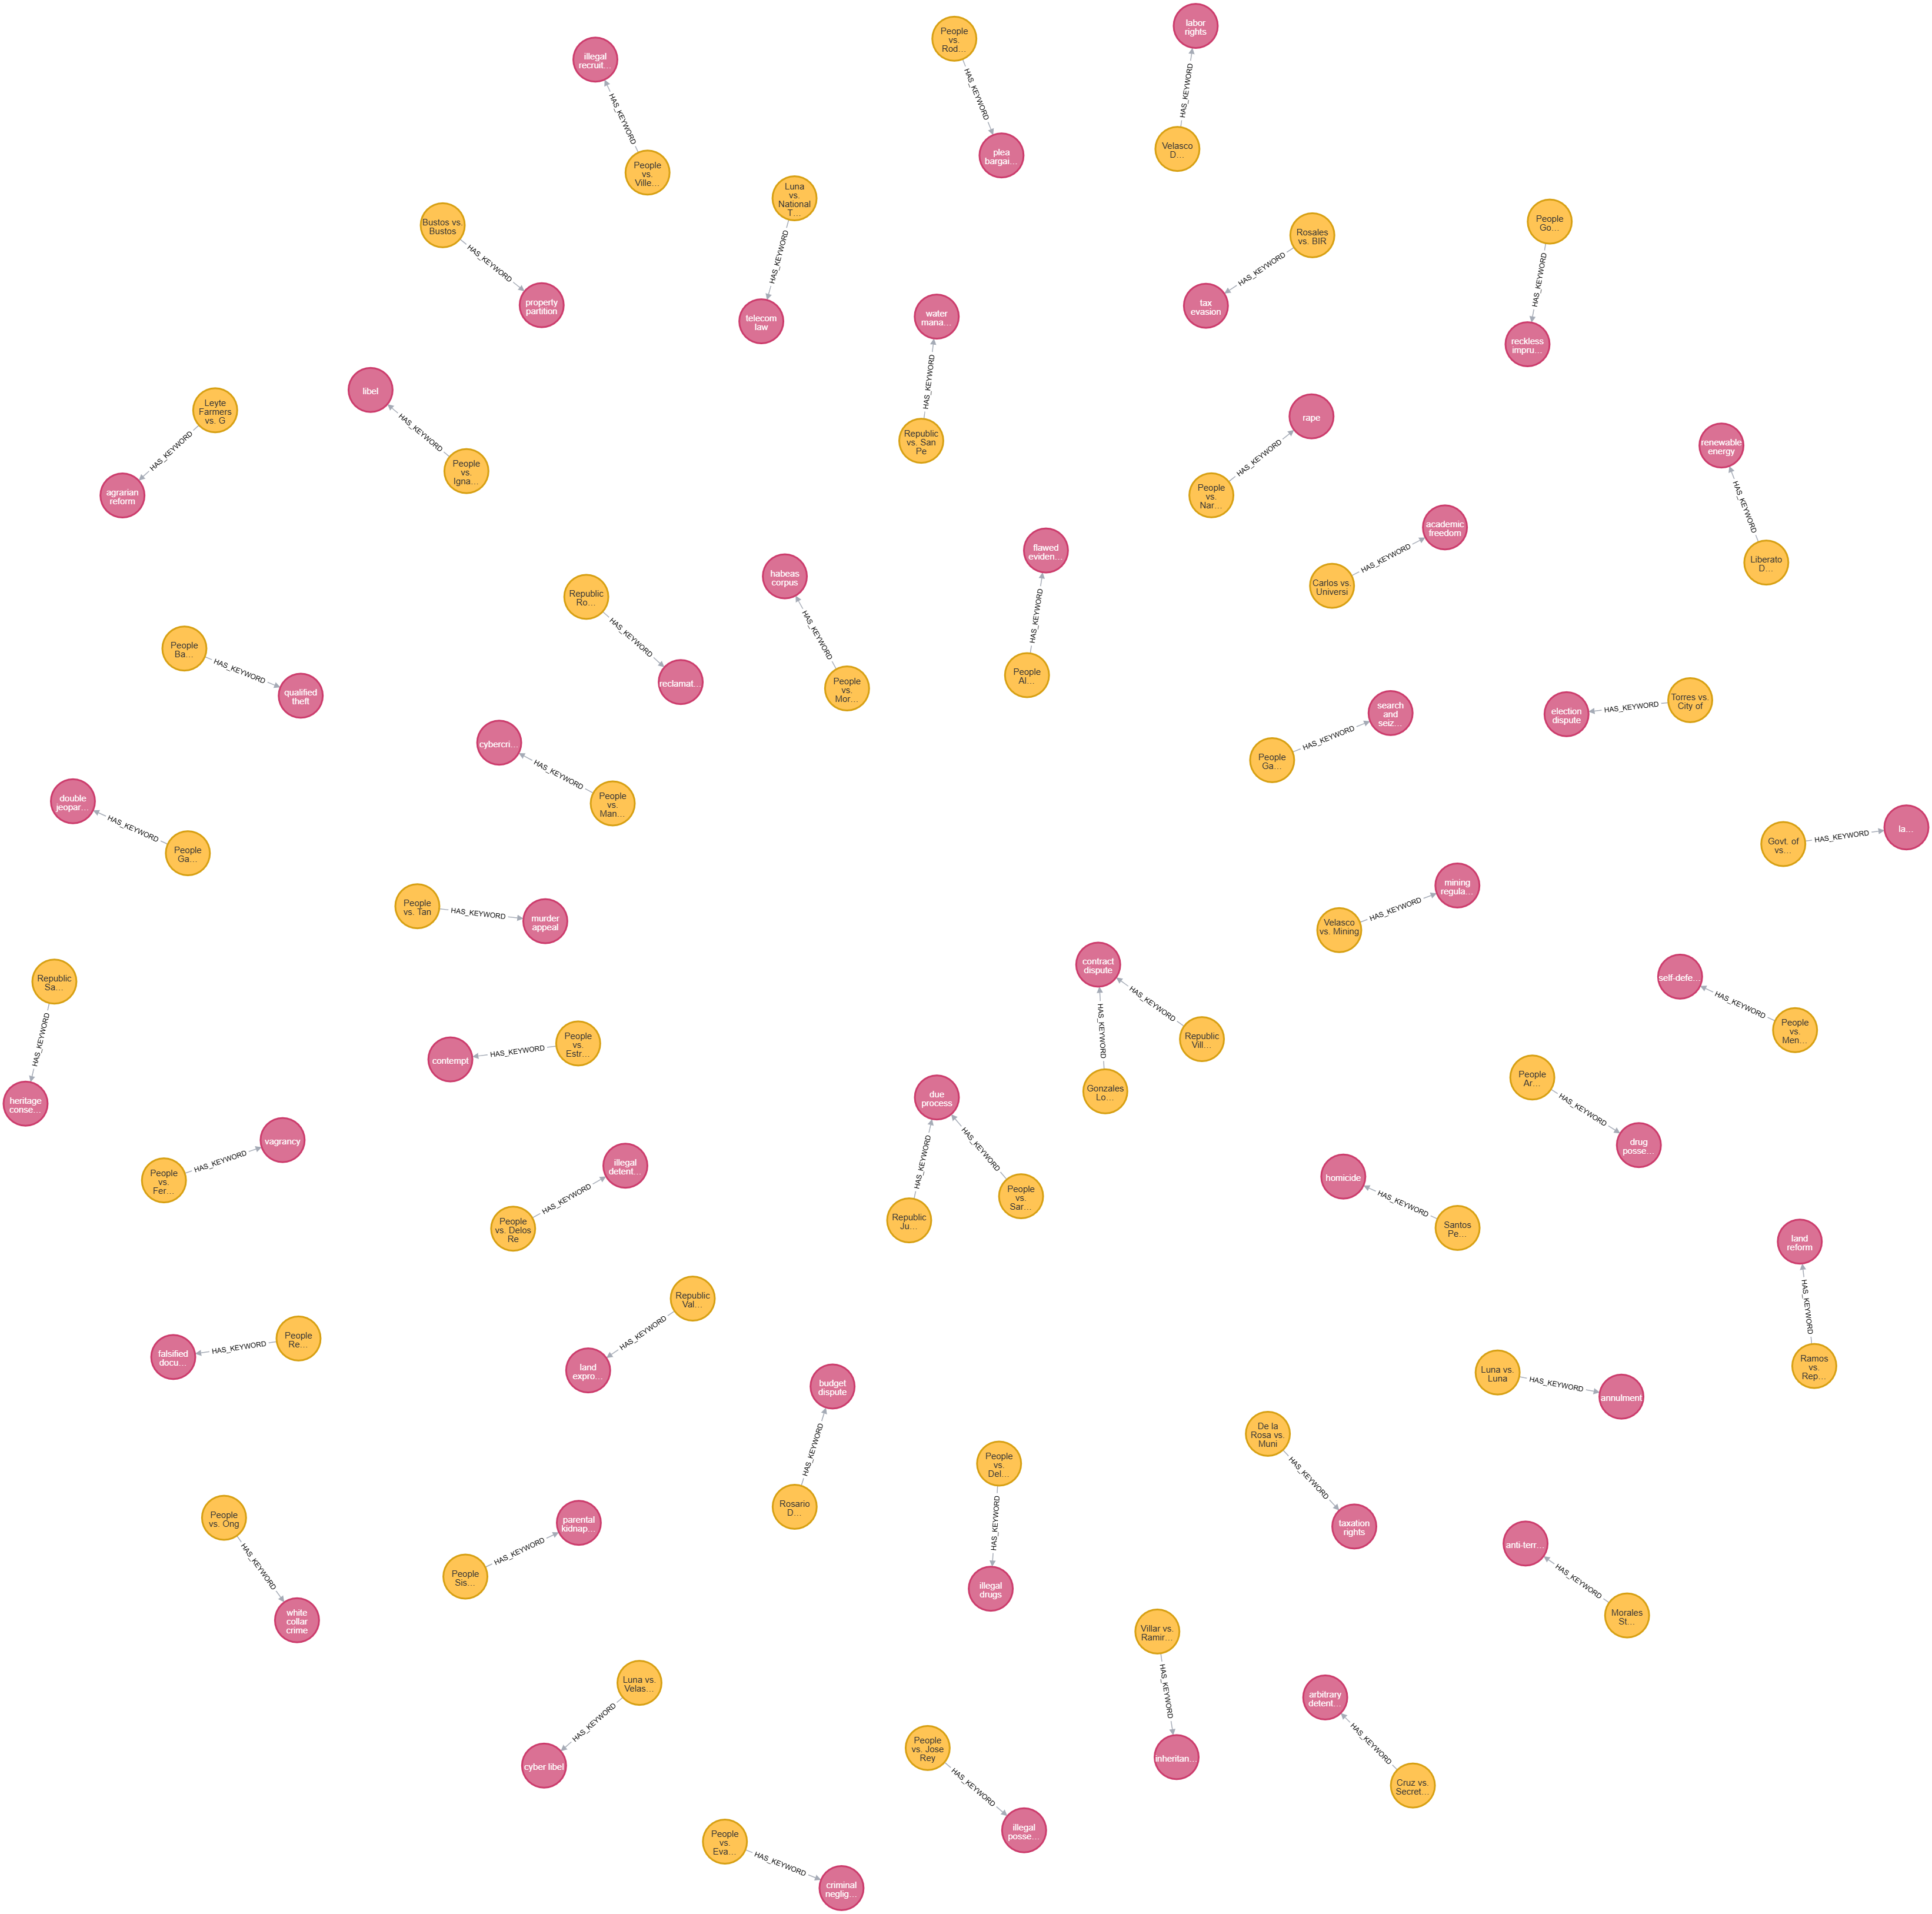

### Neo4j Vector Index

We’ll begin by implementing a vector index search to find relevant cases by their title or case summary. Recall, that the key idea is to calculate the text embedding values for each task based on their title or case summary. Then, at query time, find the most similar tasks to the user input using a similarity metric like a cosine distance.

The cases are already in our knowledge graph. However, we must calculate the embedding values and create the vector index. Here, we’ll use the `from_existing_graph` method.


In [ ]:
import os
from langchain_community.vectorstores.neo4j_vector import Neo4jVector
from langchain_openai import OpenAIEmbeddings

os.environ['OPENAI_API_KEY'] = userdata.get('openai_api_key')

vector_index = Neo4jVector.from_existing_graph(
    OpenAIEmbeddings(),
    url=NEO4J_URI,
    username=NEO4J_USERNAME,
    password=NEO4J_PASSWORD,
    index_name='case',
    node_label="Case",
    text_node_properties=['summary', 'case_id', 'title'],
    embedding_node_property='embedding',
)

Testing our similarity search

In [ ]:
response = vector_index.similarity_search(
    "Give me a case about mining or contract dispute"
)
print(response[0].page_content)


summary: Public-private partnership contract dispute.
case_id: GR10019
title: Republic vs. Villarosa


Now, we can easily create a chatbot response by wrapping the vector index into a `RetrievalQA` module.

In [ ]:
from langchain.chains import RetrievalQA
from langchain.chat_models import ChatOpenAI

vector_qa = RetrievalQA.from_chain_type(
    llm=ChatOpenAI(),
    chain_type="stuff",
    retriever=vector_index.as_retriever()
)
vector_qa.invoke(
    "Give me a case about mining or contract dispute"
)

{'query': 'Give me a case about mining or contract dispute',
 'result': 'I have a case about each of those topics:\n\n1. For a case about a contract dispute, you can refer to "Republic vs. Villarosa" (Case ID: GR10019).\n2. For a case about mining, you can look into "Velasco vs. Mining Corp." (Case ID: GR10014).'}

One general limitation of vector indexes is they don’t provide the ability to aggregate information like you would using a structured query language like Cypher. Consider the following example:

In [ ]:
vector_qa.run(
    "How many cases do you know about mining regulations or contract dispute?"
)

'I know about two cases related to mining regulations or contract disputes.'

There are 3 cases in our graph. Vector similarity search is excellent for sifting through relevant information in unstructured text, but lacks the capability to analyze and aggregate structured information. Using Neo4j, this problem is easily solved by employing Cypher, a structured query language for graph databases.

### Graph Cypher Search

Cypher is a structured query language designed to interact with graph databases.

The neat thing about `LangChain` is that it provides a `GraphCypherQAChain`, which generates the Cypher queries for us, so we don’t have to learn Cypher syntax to retrieve information from a graph database like Neo4j.

The following code will refresh the graph schema and instantiate the Cypher chain.

In [ ]:
from langchain.graphs import Neo4jGraph
graph = Neo4jGraph(
    url=NEO4J_URI,
    username=NEO4J_USERNAME,
    password=NEO4J_PASSWORD,
)

In [ ]:
from langchain.chains import GraphCypherQAChain

graph.refresh_schema()

cypher_chain = GraphCypherQAChain.from_llm(
    cypher_llm = ChatOpenAI(temperature=0, model_name='gpt-4'),
    qa_llm = ChatOpenAI(temperature=0), graph=graph, verbose=True, allow_dangerous_requests=True
)

Generating valid Cypher statements is a complex task. Therefore, it is recommended to use state-of-the-art LLMs like gpt-4 to generate Cypher statements.

Now, we can ask the same question about the number of about mining regulations or contract dispute.

In [ ]:
cypher_chain.run(
    "How many cases do you know about mining regulations or contract dispute?"
)



> Entering new GraphCypherQAChain chain...
Generated Cypher:
MATCH (c:Case)-[:HAS_KEYWORD]->(k:Keyword)
WHERE k.name IN ['mining regulations', 'contract dispute']
RETURN COUNT(DISTINCT c)
Full Context:
[{'COUNT(DISTINCT c)': 3}]

> Finished chain.


'I know about 3 cases related to mining regulations or contract disputes.'

### Knowledge Graph Agent

We’ve implemented separate tools for the structured and unstructured parts of the knowledge graph. Now we can add an agent to use these tools to explore the knowledge graph.

In [ ]:
from langchain.agents import initialize_agent, Tool
from langchain.agents import AgentType

tools = [
    Tool(
        name="Cases",
        func=vector_qa.run,
        description="""Useful when you need to retrieve case summaries.
        Not useful for counting the number of cases.
        Use full question as input.
        """,
    ),
    Tool(
        name="Graph",
        func=cypher_chain.run,
        description="""Useful when you need to answer questions about cases,
        their dependencies to other cases. Also useful for any sort of
        aggregation like counting the number of cases.
        Use full question as input.
        """,
    ),
]

mrkl = initialize_agent(
    tools,
    ChatOpenAI(temperature=0, model_name='gpt-4'),
    agent=AgentType.OPENAI_FUNCTIONS, verbose=True
)

In [ ]:
response = mrkl.run("What is the case summary for People v Arceo?")
print(response)



> Entering new AgentExecutor chain...

Invoking: `Cases` with `People v Arceo`


The case of People vs. Arceo involved the dismissal of a drug possession charge.The case of People vs. Arceo involved the dismissal of a drug possession charge.

> Finished chain.
The case of People vs. Arceo involved the dismissal of a drug possession charge.


In [ ]:
response = mrkl.run("How many cases do you know about mining regulations or contract dispute?")
print(response)



> Entering new AgentExecutor chain...

Invoking: `Graph` with `How many cases do you know about mining regulations or contract dispute?`




> Entering new GraphCypherQAChain chain...
Generated Cypher:
MATCH (c:Case)-[:HAS_KEYWORD]->(k:Keyword)
WHERE k.name IN ['mining regulations', 'contract dispute']
RETURN COUNT(DISTINCT c)
Full Context:
[{'COUNT(DISTINCT c)': 3}]

> Finished chain.
I know about 3 cases related to mining regulations or contract disputes.I know about 3 cases related to mining regulations or contract disputes.

> Finished chain.
I know about 3 cases related to mining regulations or contract disputes.


In [ ]:
response = mrkl.run("Summarize all the cases regarding contract dispute and mining regulations")
print(response)



> Entering new AgentExecutor chain...

Invoking: `Cases` with `Summarize all the cases regarding contract dispute and mining regulations`


Two out of the four cases involve contract disputes, while the other two cases involve mining regulations and land expropriation. 

1. "Gonzales vs. Lopez" is a case involving a contract dispute and the interpretation of obligations.
2. "Republic vs. Villarosa" is a case related to a public-private partnership contract dispute.
3. "Velasco vs. Mining Corp." deals with environmental protection and mining regulations.
4. "Republic vs. Valdez" involves a dispute over land expropriation.Here are the summaries of the cases regarding contract dispute and mining regulations:

1. **Gonzales vs. Lopez**: This case involves a contract dispute and the interpretation of obligations. The main issue was the interpretation of the terms of the contract and whether one party had fulfilled their obligations under the contract.

2. **Republic vs. Villarosa**: This 

In [ ]:
query_1 = "What is the summary of the case Velasco v Mining Corp?"  # Expected to use the 'Cases' tool
response_1 = mrkl.run(query_1)
print("Response from Cases Tool:", response_1)





> Entering new AgentExecutor chain...

Invoking: `Cases` with `What is the summary of the case Velasco v Mining Corp?`


The case Velasco v. Mining Corp. involves environmental protection and mining regulations.The case Velasco v. Mining Corp. involves issues related to environmental protection and mining regulations.

> Finished chain.
Response from Cases Tool: The case Velasco v. Mining Corp. involves issues related to environmental protection and mining regulations.


In [ ]:
query_2 = "How many cases are linked to case Gonzales vs. Lopez? What is this case?"  # Expected to use the 'Graph' tool
response_2 = mrkl.run(query_2)
print("Response from Graph Tool:", response_2)



> Entering new AgentExecutor chain...

Invoking: `Graph` with `How many cases are linked to case Gonzales vs. Lopez?`




> Entering new GraphCypherQAChain chain...
Generated Cypher:
MATCH (c:Case {title: "Gonzales vs. Lopez"})-[:HAS_KEYWORD]->(k:Keyword)<-[:HAS_KEYWORD]-(linkedCase:Case) RETURN COUNT(distinct linkedCase)
Full Context:
[{'COUNT(distinct linkedCase)': 1}]

> Finished chain.
There is 1 case linked to case Gonzales vs. Lopez.
Invoking: `Cases` with `What is the case Gonzales vs. Lopez?`


The case Gonzales vs. Lopez involves a contract dispute and interpretation of obligations.The case Gonzales vs. Lopez involves a contract dispute and interpretation of obligations. There is 1 case linked to this case.

> Finished chain.
Response from Graph Tool: The case Gonzales vs. Lopez involves a contract dispute and interpretation of obligations. There is 1 case linked to this case.


# Further Readings:


*   [What Is a Knowledge Graph?](https://neo4j.com/blog/what-is-knowledge-graph/)
*   [Using a Knowledge Graph to Implement a RAG Application](https://neo4j.com/developer-blog/knowledge-graph-rag-application/)
*   [LangChain Library Adds Full Support for Neo4j Vector Index](https://neo4j.com/developer-blog/langchain-library-full-support-neo4j-vector-index/)



